In [ ]:
# run alignment of mane ORFs to gencode and orfanage to establish which ones are more similar (e-score?)
# plot e-score distribution

In [1]:
# main imports
import os
import sys
import ast
import glob
import math
import shutil
import random
import importlib
import subprocess

from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pylab as pylab
import upsetplot
import seaborn as sns

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0, "/ccb/salz8-1/avaraby/orfanage/soft")
%aimport definitions

In [20]:
# paths
base_dir = "/ccb/salz8-1/avaraby/orfanage/"

orfanage_bin = base_dir+"bin/orfanage"
gffcompare_bin = "/ccb/salz7-data/sw2/bin/gffcompare"
gffread_bin = "/ccb/salz7-data/sw2/bin/gffread"
igvtools_bin = "/ccb/salz7-data/sw/bin/igvtools"
sashimi_bin = base_dir+"bin/sashimi.py"

fa_fname = base_dir+"data/hg38.fa"
gencode_gtf_fname = base_dir+"data/gencode.v41.gtf"
refseq_gtf_fname = base_dir+"data/refseq.gtf"
mane_gtf_fname = base_dir+"data/MANE.v10.gtf"
iso_fname = base_dir+"data/chess_structure_v1.2_sorted.gtf"

gencode_outdir = base_dir+"gencode/"
refseq_outdir = base_dir+"refseq/"
figdir = base_dir+"figures/"
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [5]:
# parse the combined orf_def fasta aa file
# load transcripts into a dictionary
# add data about mane
# for every case where all 3 exist
# output 3 fasta files
# run blast command
# record e value and bit score

In [7]:
# load data
nedf = pd.read_csv(gencode_outdir+"orfNEmaneNEdef.tsv",sep="\t")
tids = set(nedf["tid"])
mane_tids = set(nedf["mane_tid"])

# extract
orf_gtf_fname = "/ccb/salz8-1/avaraby/orfanage/gencode/orf.gtf"
gtf_adjstop_fname = gencode_gtf_fname.rsplit(".",1)[0]+".adjstop.gtf"
clean_gtf_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".clean.gtf"

orfNEmaneNEdef_orf_gtf_fname = "/ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.orf.gtf"
orfNEmaneNEdef_def_gtf_fname = "/ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.def.gtf"
orfNEmaneNEdef_mane_gtf_fname = "/ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.mane.gtf"

definitions.subset_gtf(orf_gtf_fname,orfNEmaneNEdef_orf_gtf_fname,set(),tids)
definitions.subset_gtf(clean_gtf_fname,orfNEmaneNEdef_def_gtf_fname,set(),tids)
definitions.subset_gtf(mane_gtf_fname,orfNEmaneNEdef_mane_gtf_fname,set(),mane_tids)

In [8]:
# extract fasta
orfNEmaneNEdef_orf_aa_fname = "/ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.aa.orf.gtf"
orfNEmaneNEdef_def_aa_fname = "/ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.aa.def.gtf"
orfNEmaneNEdef_mane_aa_fname = "/ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.aa.mane.gtf"

cmd = [gffread_bin,
       "-y",orfNEmaneNEdef_orf_aa_fname,
       "-g",fa_fname,
       orfNEmaneNEdef_orf_gtf_fname]

print(" ".join(cmd))
subprocess.call(cmd)

cmd = [gffread_bin,
       "-y",orfNEmaneNEdef_def_aa_fname,
       "-g",fa_fname,
       orfNEmaneNEdef_def_gtf_fname]

print(" ".join(cmd))
subprocess.call(cmd)

cmd = [gffread_bin,
       "-y",orfNEmaneNEdef_mane_aa_fname,
       "-g",fa_fname,
       orfNEmaneNEdef_mane_gtf_fname]

print(" ".join(cmd))
subprocess.call(cmd)

/ccb/salz7-data/sw2/bin/gffread -y /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.aa.orf.gtf -g /ccb/salz8-1/avaraby/orfanage/data/hg38.fa /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.orf.gtf
/ccb/salz7-data/sw2/bin/gffread -y /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.aa.def.gtf -g /ccb/salz8-1/avaraby/orfanage/data/hg38.fa /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.def.gtf
/ccb/salz7-data/sw2/bin/gffread -y /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.aa.mane.gtf -g /ccb/salz8-1/avaraby/orfanage/data/hg38.fa /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef.mane.gtf


0

In [9]:
aa_dict = dict()

with open(orfNEmaneNEdef_def_aa_fname,"r") as inFP:
    cur_tid = ""
    for line in inFP:
        if line[0]==">":
            cur_tid = line[1:].strip()
            aa_dict.setdefault(cur_tid,["","",""])
        else:
            aa_dict[cur_tid][0]+=line
            
with open(orfNEmaneNEdef_orf_aa_fname,"r") as inFP:
    cur_tid = ""
    for line in inFP:
        if line[0]==">":
            cur_tid = line[1:].strip()
            assert cur_tid in aa_dict,"missing_tid: "+cur_tid
        else:
            aa_dict[cur_tid][1]+=line
            


In [10]:
mane2gen_map = dict()

# load dictionary of mane_tid to gencode_tid from the tsv
for index, row in nedf[["tid","mane_tid"]].iterrows():
    if row["tid"] in aa_dict:
        mane2gen_map.setdefault(row["mane_tid"],[])
        mane2gen_map[row["mane_tid"]].append(row["tid"])
        
print(len(mane2gen_map))

3940


In [11]:
gen2mane_map = dict()

discard_multi_mane = set()

with open(orfNEmaneNEdef_mane_aa_fname,"r") as inFP:
    cur_tid = ""
    cur_gen_tids = None
    for line in inFP:
        if line[0]==">":
            cur_tid = line[1:].strip()
            if cur_tid in mane2gen_map:
                cur_gen_tids = mane2gen_map[cur_tid]
                
                for cg in cur_gen_tids:
                    # assert cg not in gen2mane_map,"duplicate tid: "+cg+" : "+str(gen2mane_map[cg])
                    if cg in gen2mane_map:
                        discard_multi_mane.add(gen2mane_map[cg])
                    gen2mane_map[cg] = cur_tid
                
            else:
                cur_gen_tids = None
        else:
            if cur_gen_tids is not None:
                for cg in cur_gen_tids:
                    aa_dict[cg][2]+=line

In [12]:
# discard all transcripts associated with these genes
print(len(aa_dict))
for mtx in discard_multi_mane:
    for gtx in mane2gen_map[mtx]:
        del aa_dict[gtx]
        
print(len(aa_dict))

7727
7647


In [55]:
# only for those that are in all three - output files and run alignment

if not os.path.exists(gencode_outdir+"orfNEmaneNEdef_aligned"):
    os.mkdir(gencode_outdir+"orfNEmaneNEdef_aligned")

with open(gencode_outdir+"orfNEmaneNEdef_aligned/res.csv","w+") as resFP:
    resFP.write("tid,mane_tid,def_ident,orf_ident\n")
    for k,v in aa_dict.items():
        # if not k == "ENST00000620552.4":
        #     continue
        if len(v[2])==0:
            continue
        with open(gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.def.fa","w+") as outFP:
            outFP.write(">"+k+"_def\n")
            outFP.write(v[0]+"\n")
        with open(gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.orf.fa","w+") as outFP:
            outFP.write(">"+k+"_orf\n")
            outFP.write(v[1]+"\n")
        with open(gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.mane.fa","w+") as outFP:
            outFP.write(">"+k+"_mane\n")
            outFP.write(v[2]+"\n")

        cmd_def = ["stretcher",
                   "-asequence",gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.def.fa",
                   "-bsequence",gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.mane.fa",
                   "-outfile",gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.def.aln",
                   "-aformat","markx10"]

        cmd_orf = ["stretcher",
                   "-asequence",gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.orf.fa",
                   "-bsequence",gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.mane.fa",
                   "-outfile",gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.orf.aln",
                   "-aformat","markx10"]

        try:
            subprocess.call(cmd_def)
            subprocess.call(cmd_orf)

            # read results
            def_ident = None
            orf_ident = None
            with open(gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.def.aln","r") as inFP:
                for line in inFP:
                    if line.startswith("; sw_ident:"):
                        def_ident = line.strip().split(": ")[1]

            with open(gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.orf.aln","r") as inFP:
                for line in inFP:
                    if line.startswith("; sw_ident:"):
                        orf_ident = line.strip().split(": ")[1]

            assert def_ident is not None,"empty def_ident in: "+gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.def.aln"
            assert orf_ident is not None,"empty orf_ident in: "+gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.orf.aln"

            resFP.write(k+","+gen2mane_map[k]+","+def_ident+","+orf_ident+"\n")
        except:
            pass
        
        fnames = [gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.def.fa",
                  gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.orf.fa",
                  gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.mane.fa",
                  gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.def.aln",
                  gencode_outdir+"orfNEmaneNEdef_aligned/"+k+".aa.orf.aln"]
        for fn in fnames:
            try:
                os.remove(fn)
            except:
                continue

Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global alignment of two sequences
Needleman-Wunsch rapid global a

In [56]:
df = pd.read_csv(gencode_outdir+"orfNEmaneNEdef_aligned/res.csv")
df.columns = ["tid","mane_tid","GENCODE","ORFanage"]
df["GENCODE"] = df["GENCODE"]*100
df["ORFanage"] = df["ORFanage"]*100
dfl = df[["GENCODE","ORFanage"]].melt()
dfl.columns = ["Method","%Identity"]
dfl["x"] = ""

df = df.merge(nedf[["tid","ilpd_orf","ilpd_def"]],on="tid",how="left")
df.head()

,tid,mane_tid,GENCODE,ORFanage,ilpd_orf,ilpd_def
0,ENST00000620552.4,ENST00000379370.7,92.2,98.9,100,93
1,ENST00000467751.5,ENST00000421241.7,25.3,40.9,38,12
2,ENST00000477196.5,ENST00000421241.7,25.2,31.4,54,12
3,ENST00000465727.5,ENST00000360001.12,55.2,55.8,52,52
4,ENST00000450390.6,ENST00000349431.11,16.6,84.2,83,16


In [57]:
pd_v_pi = pd.concat([df[["ilpd_orf","ORFanage"]].rename({"ilpd_orf":"ILPD","ORFanage":"PI"},axis=1),df[["ilpd_def","GENCODE"]].rename({"ilpd_def":"ILPD","GENCODE":"PI"},axis=1)],axis=0)

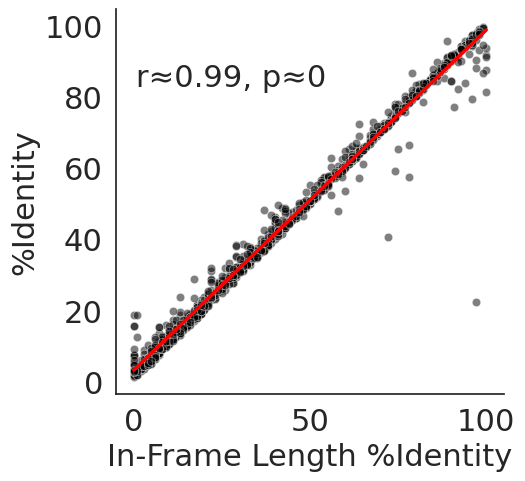

In [63]:
params = {'figure.figsize': (5,5),
          'legend.fontsize': 22,
          'axes.labelsize': 22,
          'axes.titlesize': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
pylab.rcParams.update(params)

subdata = pd_v_pi.sample(1000)

sns.scatterplot(data=subdata, x="ILPD", y="PI",alpha=0.5,marker="o",color="black")
sns.regplot(data=subdata, x="ILPD", y="PI", scatter = False, ci = 50, 
    fit_reg = True, color = 'red') 
sns.regplot(data=subdata, x="ILPD", y="PI", scatter = False, ci = 0, 
    fit_reg = True, color = 'red')

r, p = stats.pearsonr(subdata['ILPD'], subdata['PI'])
ax = plt.gca()
ax.text(.05, .8, 'r\u2248{:.2g}, p\u2248{:.2g}'.format(r, p),transform=ax.transAxes,fontsize=22)

sns.despine()
plt.xlabel("In-Frame Length %Identity")
plt.ylabel("%Identity")
plt.savefig(figdir+"pi_vs_ilpi.gencode.svg")

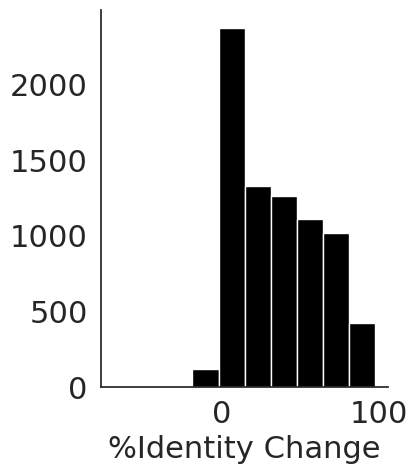

In [59]:
params = {'figure.figsize': (3.7,4.9),
          'legend.fontsize': 22,
          'axes.labelsize': 22,
          'axes.titlesize': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
pylab.rcParams.update(params)
plt.hist(df["ORFanage"]-df["GENCODE"],bins=10,color="black")
plt.xlabel("%Identity Change")
sns.despine()
plt.savefig(figdir+"percent_identity_change.gencode.svg")

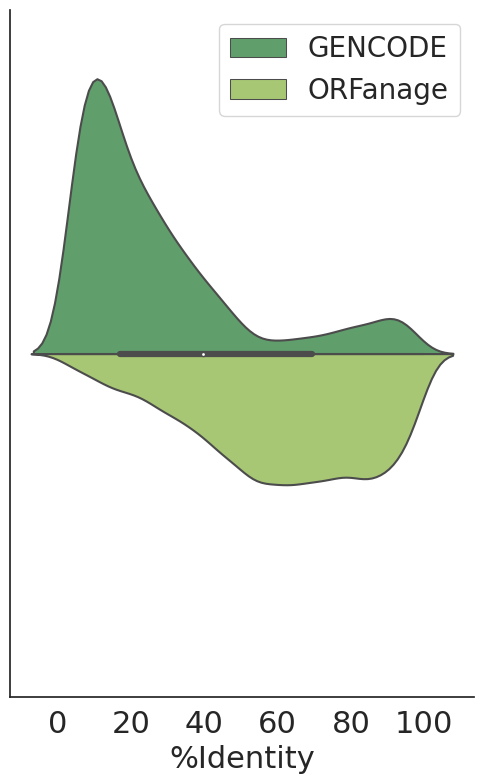

In [60]:
params = {'figure.figsize': (5,8),
          'legend.fontsize': 22,
          'axes.labelsize': 22,
          'axes.titlesize': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
pylab.rcParams.update(params)

fig, ax = plt.subplots()
sns.set_theme(style="white")
sns.violinplot(ax=ax,
               x="%Identity",
               data=dfl,
               y='x',
               hue='Method',
               palette='summer',
               split=True,
               orient='h',
               fontsize=22)
plt.legend(fontsize=20)
ax.set_ylabel("")
sns.despine()
plt.tight_layout()
plt.savefig(figdir+"percent_identity.gencode.svg")